In [115]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pydicom
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm
import cv2
import glob
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import torchvision.transforms as transforms
import torchvision.utils as vutils


In [101]:

# Laad de CSV-bestanden
data_dir = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification'
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
label_coords_df = pd.read_csv(os.path.join(data_dir, 'train_label_coordinates.csv'))
series_desc_df = pd.read_csv(os.path.join(data_dir, 'train_series_descriptions.csv'))

# Combineer de gegevens op basis van study_id en series_id
merged_df = label_coords_df.merge(series_desc_df, on=['study_id', 'series_id'])
merged_df = merged_df.merge(train_df, on='study_id')

# Voeg een kolom toe voor de image path
merged_df['image_path'] = merged_df.apply(lambda row: os.path.join(data_dir, 'train_images', str(row['study_id']), str(row['series_id']), f"{row['instance_number']}.dcm"), axis=1)

# Selecteer relevante kolommen voor classificatie (pas deze aan naar je eigen taak)
conditions = [
    'spinal_canal_stenosis_l1_l2', 'spinal_canal_stenosis_l2_l3', 'spinal_canal_stenosis_l3_l4',
    'spinal_canal_stenosis_l4_l5', 'spinal_canal_stenosis_l5_s1',
    'left_neural_foraminal_narrowing_l1_l2', 'left_neural_foraminal_narrowing_l2_l3',
    'left_neural_foraminal_narrowing_l3_l4', 'left_neural_foraminal_narrowing_l4_l5'
]

# Houd alleen de rijen waar alle condities beschikbaar zijn
merged_df = merged_df.dropna(subset=conditions)

In [102]:
# List out all of the Studies we have on patients.
part_1 = os.listdir('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images')
part_1 = list(filter(lambda x: x.find('.DS') == -1, part_1))


df_meta_f = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')

p1 = [(x, f"/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/{x}") for x in part_1]
meta_obj = { p[0]: { 'folder_path': p[1], 
                    'SeriesInstanceUIDs': [] 
                   } 
            for p in p1 }
for m in meta_obj:
    meta_obj[m]['SeriesInstanceUIDs'] = list(
        filter(lambda x: x.find('.DS') == -1, 
               os.listdir(meta_obj[m]['folder_path'])
              )
    )


# grabs the correspoding series descriptions
for k in tqdm(meta_obj):
    for s in meta_obj[k]['SeriesInstanceUIDs']:
        if 'SeriesDescriptions' not in meta_obj[k]:
            meta_obj[k]['SeriesDescriptions'] = []
        try:
            meta_obj[k]['SeriesDescriptions'].append(
                df_meta_f[(df_meta_f['study_id'] == int(k)) & 
                (df_meta_f['series_id'] == int(s))]['series_description'].iloc[0])
        except:
            print("Failed on", s, k)

meta_obj[list(meta_obj.keys())[1]]
patient = train_df.iloc[1]
ptobj = meta_obj[str(patient['study_id'])]

100%|██████████| 1975/1975 [00:03<00:00, 520.89it/s]


In [103]:
meta_obj[list(meta_obj.keys())[1]]

{'folder_path': '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1972129014',
 'SeriesInstanceUIDs': ['2898623075', '3324327485', '3203550406'],
 'SeriesDescriptions': ['Sagittal T2/STIR', 'Axial T2', 'Sagittal T1']}

In [104]:
patient = train_df.iloc[1]

In [105]:
df_coor = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')

In [106]:
ptobj = meta_obj[str(patient['study_id'])]

In [107]:
im_list_dcm = {}
for idx, i in enumerate(ptobj['SeriesInstanceUIDs']):
    im_list_dcm[i] = {'images': [], 'description': ptobj['SeriesDescriptions'][idx]}
    images = glob.glob(f"{ptobj['folder_path']}/{ptobj['SeriesInstanceUIDs'][idx]}/*.dcm")
    for j in sorted(images, key=lambda x: int(x.split('/')[-1].replace('.dcm', ''))):
        im_list_dcm[i]['images'].append({
            'SOPInstanceUID': j.split('/')[-1].replace('.dcm', ''), 
            'dicom': pydicom.dcmread(j) })

In [108]:
def display_coor_on_img(c, i, title):
    center_coordinates = (int(c['x']), int(c['y']))
    radius = 10
    color = (255, 0, 0)  # Red color in BGR
    thickness = 2
    IMG = i['dicom'].pixel_array
    IMG_normalized = cv2.normalize(IMG, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    IMG_with_circle = cv2.circle(IMG_normalized.copy(), center_coordinates, radius, color, thickness)
    
    # Convert the image from BGR to RGB for correct color display in matplotlib
    IMG_with_circle = cv2.cvtColor(IMG_with_circle, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.imshow(IMG_with_circle)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.title(title)
    plt.show()

In [109]:
coor_entries = df_coor[df_coor['study_id'] == int(patient['study_id'])]

Only showing severe cases for this patient


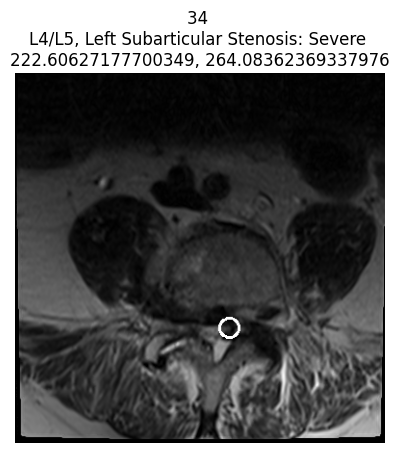

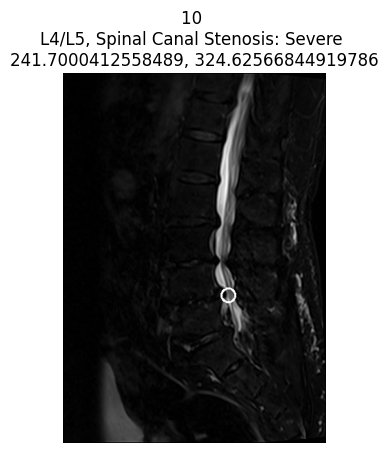

In [110]:
print("Only showing severe cases for this patient")
for idc, c in coor_entries.iterrows():
    for i in im_list_dcm[str(c['series_id'])]['images']:
        if int(i['SOPInstanceUID']) == int(c['instance_number']):
            try:
                patient_severity = patient[
                    f"{c['condition'].lower().replace(' ', '_')}_{c['level'].lower().replace('/', '_')}"
                ]
            except Exception as e:
                patient_severity = "unknown severity"
            title = f"{i['SOPInstanceUID']} \n{c['level']}, {c['condition']}: {patient_severity} \n{c['x']}, {c['y']}"
            if patient_severity == 'Severe':
                display_coor_on_img(c, i, title)

In [113]:
class SpineDataset(Dataset):
    def __init__(self, df_coor, meta_obj, transform=None, image_type='Sagittal', max_images_per_study=20):
        self.df_coor = df_coor
        self.meta_obj = meta_obj
        self.transform = transform
        self.study_ids = list(meta_obj.keys())
        self.image_type = image_type
        self.max_images_per_study = max_images_per_study

    def __len__(self):
        return len(self.study_ids)

    def __getitem__(self, idx):
        study_id = self.study_ids[idx]
        study_info = self.meta_obj[study_id]
        folder_path = study_info['folder_path']
        series_instance_uids = [
            uid for uid, desc in zip(study_info['SeriesInstanceUIDs'], study_info['SeriesDescriptions']) 
            if self.image_type in desc
        ]  # Filter alleen series met het juiste type afbeelding
        
        images = []
        for series_id in series_instance_uids:
            # Filter coördinaten voor deze studie en serie
            series_coor = self.df_coor[(self.df_coor['study_id'] == int(study_id)) &
                                       (self.df_coor['series_id'] == int(series_id))]

            for instance_num in series_coor['instance_number'].unique():
                img_name = f"{instance_num}.dcm"
                img_path = os.path.join(folder_path, series_id, img_name)
                
                # Open het DICOM-bestand en converteer naar een beeld
                dicom = pydicom.dcmread(img_path)
                img = apply_voi_lut(dicom.pixel_array, dicom)
                
                # Converteer naar 8-bits en normaliseer het beeld
                img = img.astype(np.float32)
                img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
                
                # Converteer naar RGB-beeld
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                img = Image.fromarray(img)

                # Zoek de coördinaten voor dit beeld en teken cirkels
                coor_entries = series_coor[series_coor['instance_number'] == instance_num]
                draw = ImageDraw.Draw(img)

                for _, coor_entry in coor_entries.iterrows():
                    x, y = int(coor_entry['x']), int(coor_entry['y'])

                    # Teken een cirkel rond de coördinaten
                    radius = 10
                    draw.ellipse((x - radius, y - radius, x + radius, y + radius), outline="red", width=2)
                    
                    # Hier kunnen we kiezen om een crop rond het punt te maken of de hele afbeelding behouden
                    cropped_img = img

                    if self.transform:
                        cropped_img = self.transform(cropped_img)
                    
                    images.append(cropped_img)
        
        # Pad de lijst met afbeeldingen met dummy-afbeeldingen om de vaste grootte te bereiken
        if len(images) < self.max_images_per_study:
            while len(images) < self.max_images_per_study:
                images.append(torch.zeros((3, 224, 224)))
        elif len(images) > self.max_images_per_study:
            images = images[:self.max_images_per_study]
        
        # Combineer alle cropped images tot één tensor
        images = torch.stack(images)

        # Dummy label (vervang dit met echte label-implementatie)
        label = torch.tensor(0)  # One-hot encoding vervangen
        return images, label
        

# Definieer de transformaties inclusief resize
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Voeg deze regel toe om alle afbeeldingen te schalen naar 224x224 pixels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def custom_collate_fn(batch):
    images = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    return images, labels

# Dataset en DataLoader
patient_ids = df_coor['study_id'].unique()
dataset = SpineDataset(df_coor,  meta_obj, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=custom_collate_fn)


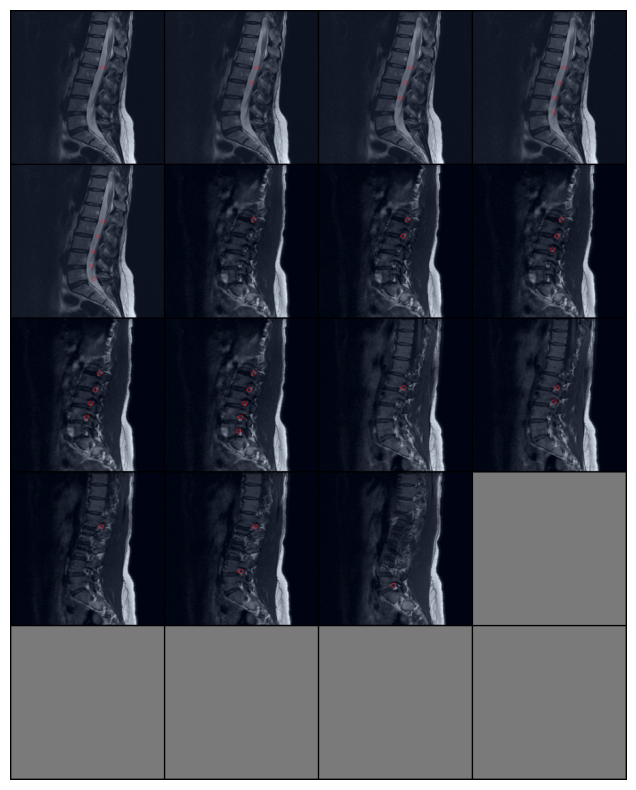

In [114]:
# Haal een batch op uit de DataLoader
dataiter = iter(dataloader)
images_list, labels_list = next(dataiter)

# Maak een grid van de eerste batch afbeeldingen van de eerste studie
def show_images_grid(images, nrow=4):
    plt.figure(figsize=(10,10))
    grid_img = vutils.make_grid(images.view(-1, 3, 224, 224), nrow=nrow, padding=2, normalize=True)
    plt.imshow(np.transpose(grid_img.cpu(), (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Toon de grid van de eerste studie in de batch
show_images_grid(images_list[0])